# VaR-Rule for Foreign Exchange Interventions

This notebook replicates the tables and the charts of the IMF WP on VaR-Rule for Foreign Exchange Interventions

It uses a Python package that I have written, DistGARCH, also available in this Github folder, with the public FX intervention data from the Banco Mexico. DistGARCH is based on the ARCH package of Kevin Sheppard.

You can use the code for non-commercial applications, providing that you cite the  IMF Working Paper\
Lafarguette, R. and Veyrune, R. (2020) *VaR-Rule for Foreign Exchange Interventions*,
IMF Working Paper no 20XX

Author: Romain Lafarguette, August 2020\
If you have any question, please contact me via Github or rlafarguette "at" imf "dot" org

## Preamble

In [1]:
# System paths
import os, sys
sys.path.append(os.path.abspath('modules'))

# Global modules
import importlib                                        # Operating system
import pandas as pd                                     # Dataframes
import numpy as np                                      # Numeric Python
import datetime                                         # Dates
import arch                                             # ARCH/GARCH models

# Functional imports
from datetime import datetime as date                   # Short date function
from dateutil.relativedelta import relativedelta        # Dates manipulation 

# ARCH package functional imports
from arch.univariate import ARX # Drift model
from arch.univariate import (ARCH, GARCH, EGARCH, EWMAVariance, # Vol process
                             FixedVariance, RiskMetrics2006) 
from arch.univariate import (Normal, StudentsT, # Distribution of residuals
                             SkewStudent, GeneralizedError)

# Local modules
import distGARCH; importlib.reload(distGARCH)           # Distributional GARCH
from distGARCH import DistGARCH

# Graphics
%matplotlib inline
import matplotlib.pyplot as plt                         # Graphical package  
import seaborn as sns                                   # Graphical tools

plt.rcParams["figure.figsize"]=25,15

sns.set(style='white', font_scale=2, palette='deep', font='Arial')

# Ignore a certain type of warnings which occurs in ML estimation
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
# Read the data for Mexico
df = pd.read_csv(os.path.join('data', 'MXN_data.csv'), parse_dates=['date'], index_col=[0])

### Figure 1: Conditional VaR and density (diagram)

<div>
<img src="img/VaR_concept.PNG" width="800"/>
</div>


## Fit the GARCH model for different specifications

In [3]:
# Prepare the list of variables
constant = []

microstructure = ['Bid-ask spread abs value',
                  'Forward points first difference']

cip = microstructure + ['Interbank rate vs Libor']

baseline = cip + ['VIX first diff', 'EURUSD log returns']

# List of models
models_l = [constant, microstructure, cip, baseline]
labels_l = ['Constant', 'Microstructure', 'CIP', 'Baseline']

specification_tables_l = list()

for label, model in zip(labels_l, models_l):
    dgm = DistGARCH(depvar_str='FX log returns',
                    data=df,
                    level_str='FX level', 
                    exog_l=model, 
                    lags_l=[1], 
                    vol_model=EGARCH(1,1,1),
                    dist_family=SkewStudent())

    # Fit the model
    dgfit = dgm.fit()

    # Generate the tables
    var_d = {'FX l...rns[1]':'Lag FX log returns'}
    sumtable = dgfit.summary_table(model_name=label, var_d=var_d)
    specification_tables_l.append(sumtable)
    
    
# Merge all the summary tables (need to reorder some rows)
dsum = pd.concat(specification_tables_l, axis=1)




                                AR - EGARCH Model Results                                
Dep. Variable:                    FX log returns   R-squared:                      -0.000
Mean Model:                                   AR   Adj. R-squared:                 -0.001
Vol Model:                                EGARCH   Log-Likelihood:               -23031.3
Distribution:      Standardized Skew Student's t   AIC:                           46078.6
Method:                       Maximum Likelihood   BIC:                           46129.4
                                                   No. Observations:                 4221
Date:                           Sat, Aug 15 2020   Df Residuals:                     4213
Time:                                   16:50:24   Df Model:                            8
                                   Mean Model                                   
                    coef    std err          t      P>|t|       95.0% Conf. Int.
----------------------------

                               AR-X - EGARCH Model Results                               
Dep. Variable:                    FX log returns   R-squared:                       0.137
Mean Model:                                 AR-X   Adj. R-squared:                  0.135
Vol Model:                                EGARCH   Log-Likelihood:               -22781.9
Distribution:      Standardized Skew Student's t   AIC:                           45589.8
Method:                       Maximum Likelihood   BIC:                           45672.3
                                                   No. Observations:                 4221
Date:                           Sat, Aug 15 2020   Df Residuals:                     4208
Time:                                   16:50:25   Df Model:                           13
                                            Mean Model                                            
                                      coef    std err          t      P>|t|       95.0% Con

## Table 1: Results of the GARCH Estimates for different specifications

In [4]:
new_index = ['Intercept', 'Lag FX log returns', 'Bid-ask spread abs value', 'Forward points first difference',
            'Interbank rate vs Libor', 'VIX first diff', 'EURUSD log returns', 
            'Omega', 'Alpha', 'Gamma', 'Beta', 'Nu', 'Lambda', 
            'R2', 'R2 adjusted', 'Number of observations', 
            'Pvalue in parenthesis', 'Significance thresholds: *10%, **5%, ***1%']

dsum.loc[new_index, :]


,Constant,Microstructure,CIP,Baseline
Intercept,1.159 \n (0.139),-2.075 \n (0.182),2.482*** \n (0.0),2.117 \n (0.322)
Lag FX log returns,0.012 \n (0.476),0.008 \n (0.597),0.005 \n (0.659),0.009 \n (0.542)
Bid-ask spread abs value,NaN,0.106** \n (0.011),0.147*** \n (0.0),0.167*** \n (0.0)
Forward points first difference,NaN,0.307*** \n (0.0),0.301*** \n (0.0),0.254*** \n (0.0)
Interbank rate vs Libor,NaN,NaN,-1.145*** \n (0.0),-1.174*** \n (0.002)
VIX first diff,NaN,NaN,NaN,9.709*** \n (0.0)
EURUSD log returns,NaN,NaN,NaN,0.124*** \n (0.0)
Omega,0.118*** \n (0.0),0.102*** \n (0.001),0.091*** \n (0.002),0.101*** \n (0.001)
Alpha,0.14*** \n (0.0),0.152*** \n (0.0),0.147*** \n (0.0),0.151*** \n (0.0)
Gamma,0.067*** \n (0.0),0.059*** \n (0.0),0.059*** \n (0.0),0.049*** \n (0.0)


## Baseline GARCH Model: Fit and Forecast

In [5]:
#### Specify the model
exog_l = ['Bid-ask spread abs value',
          'Forward points first difference', 
          'Interbank rate vs Libor',
          'VIX first diff',
          'EURUSD log returns',
]

dg = DistGARCH(depvar_str='FX log returns',
               data=df,
               level_str='FX level', 
               exog_l=exog_l, 
               lags_l=[1], 
               vol_model=EGARCH(1,1,1),
               # ARCH(1,1), EGARCH(1,1,1), GARCH(1,1),
               # EWMAVariance(None), RiskMetrics2006(),
               dist_family=SkewStudent(),
               # Normal, StudentsT, SkewStudent(), GeneralizedError()
)

# Fit the model
dgf = dg.fit()

# Forecast for 2020
dgfor = dgf.forecast('2020-01-01', horizon=1)


                               AR-X - EGARCH Model Results                               
Dep. Variable:                    FX log returns   R-squared:                       0.137
Mean Model:                                 AR-X   Adj. R-squared:                  0.135
Vol Model:                                EGARCH   Log-Likelihood:               -22781.9
Distribution:      Standardized Skew Student's t   AIC:                           45589.8
Method:                       Maximum Likelihood   BIC:                           45672.3
                                                   No. Observations:                 4221
Date:                           Sat, Aug 15 2020   Df Residuals:                     4208
Time:                                   16:51:03   Df Model:                           13
                                            Mean Model                                            
                                      coef    std err          t      P>|t|       95.0% Con

### Figure 2. Mexican Peso Against US Dollar

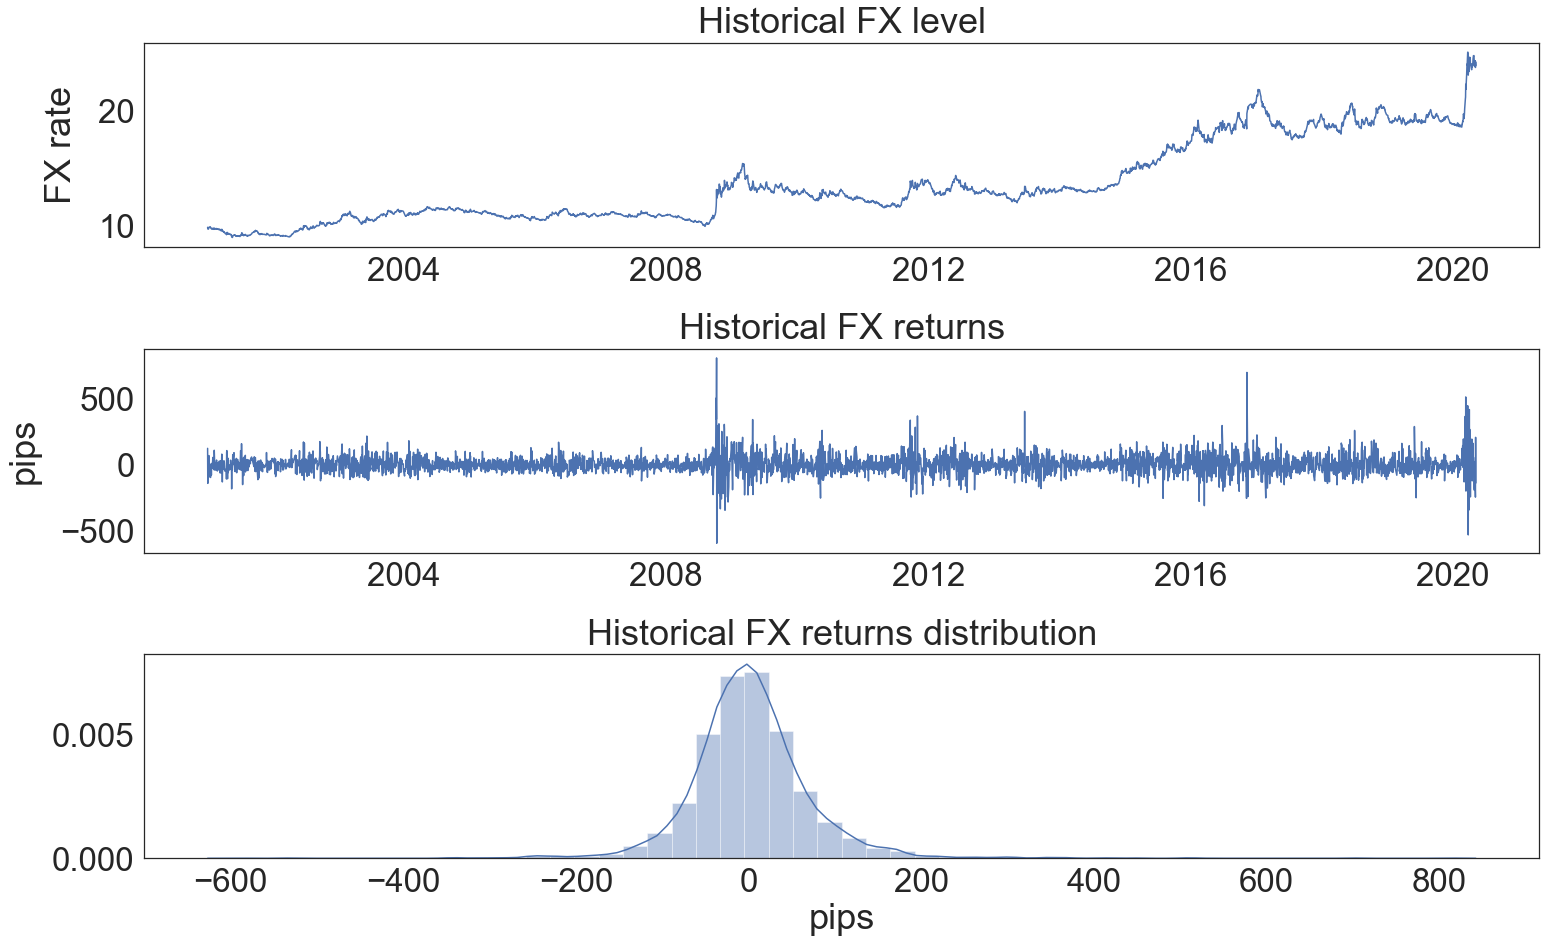

In [6]:
dg.plot_description(title_level='Historical FX level',
                    title_returns='Historical FX returns',
                    title_density='Historical FX returns distribution',
                    font_scale=3)

plt.show()

### Figure 3. Conditional FX Volatility Over Time

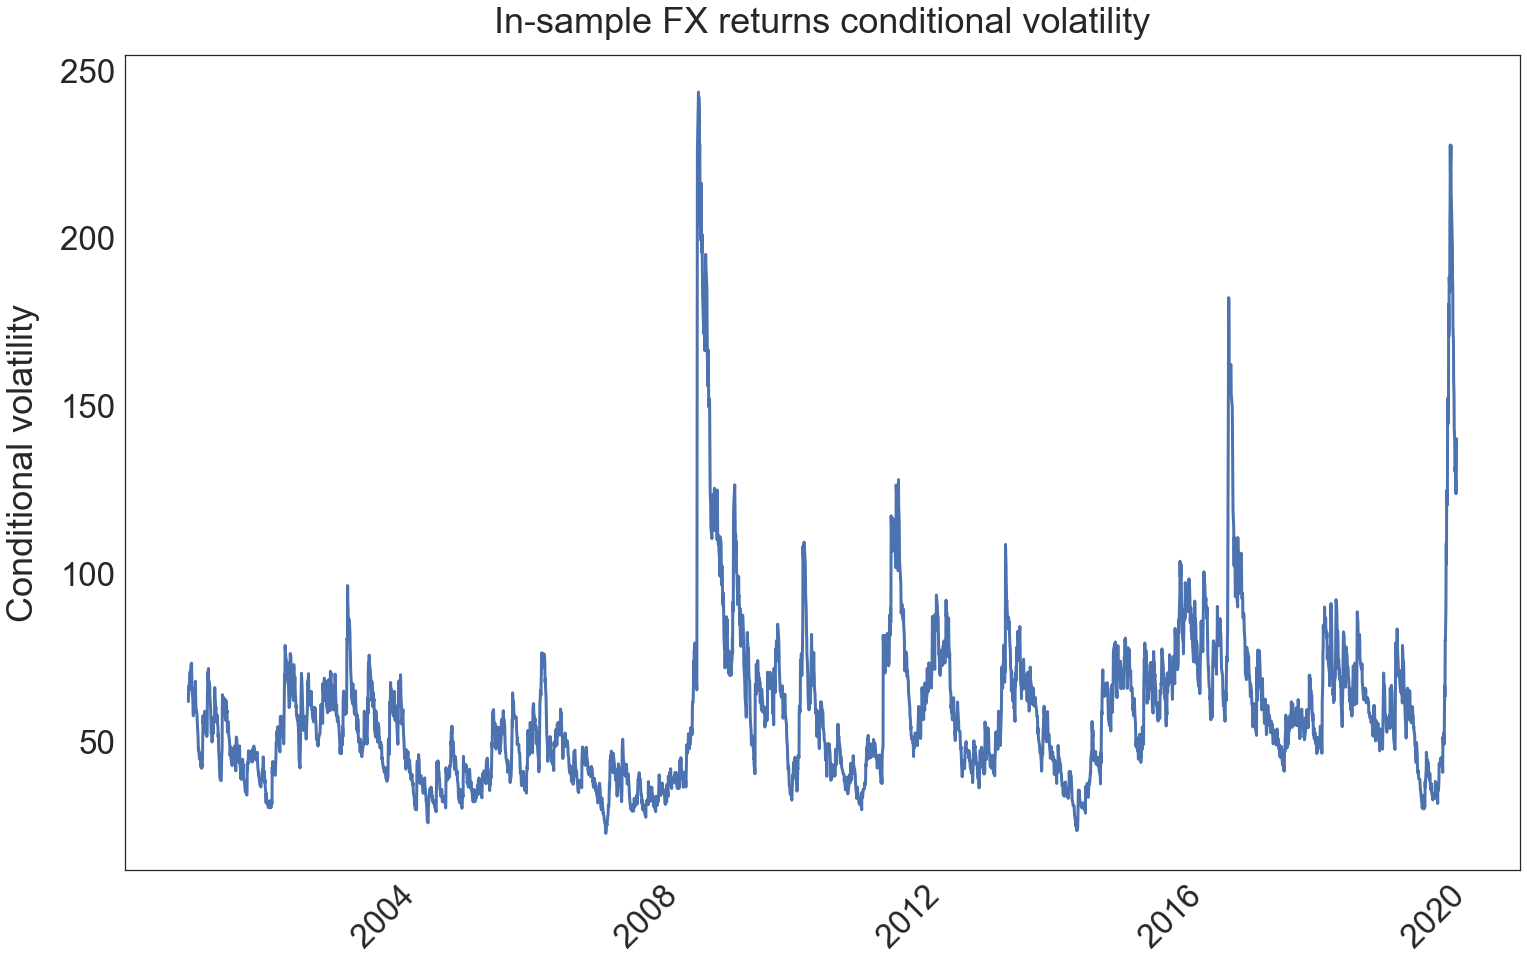

In [7]:
dgf.plot_in_cond_vol(start_date=None,
                     title='In-sample FX returns conditional volatility',
                     font_scale=3)
plt.show()


### Figure 4. Out-of-sample Conditional Density

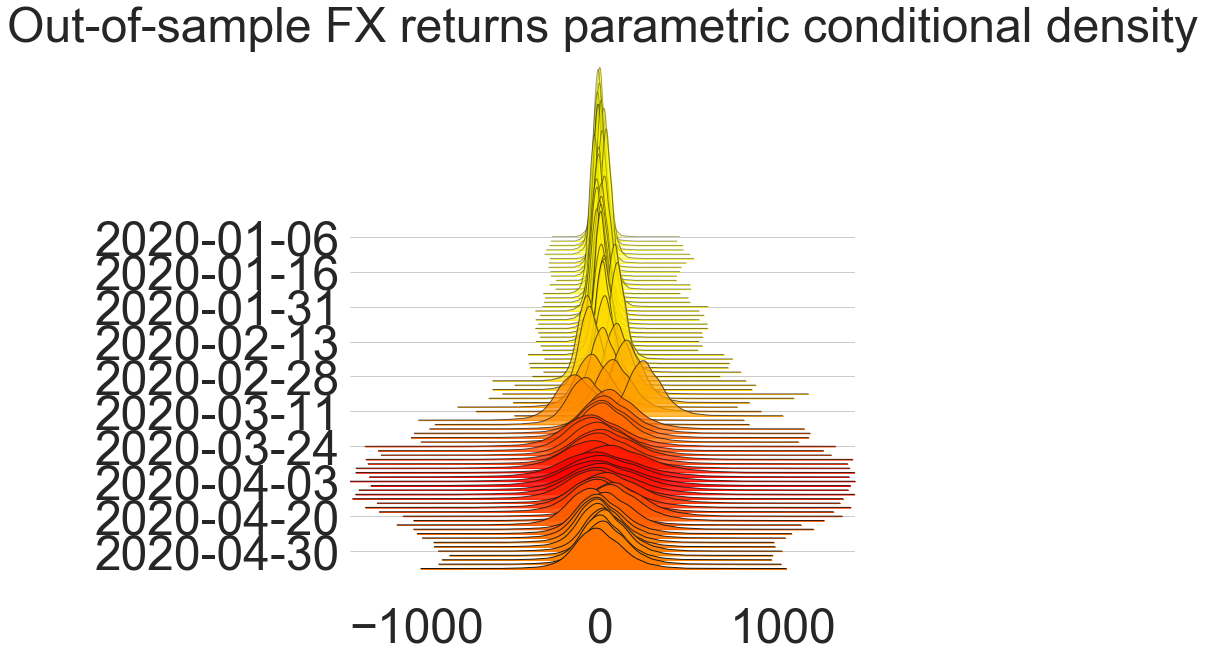

In [8]:
dgfor.joyplot_out(
    title='Out-of-sample FX returns parametric conditional density',
    xlabel='',
    label_drop=8,
    xlimits_t=(-1000, 1000),
    font_scale=4)

plt.show()


### Figure 5. Out-of-Sample Fan Chart

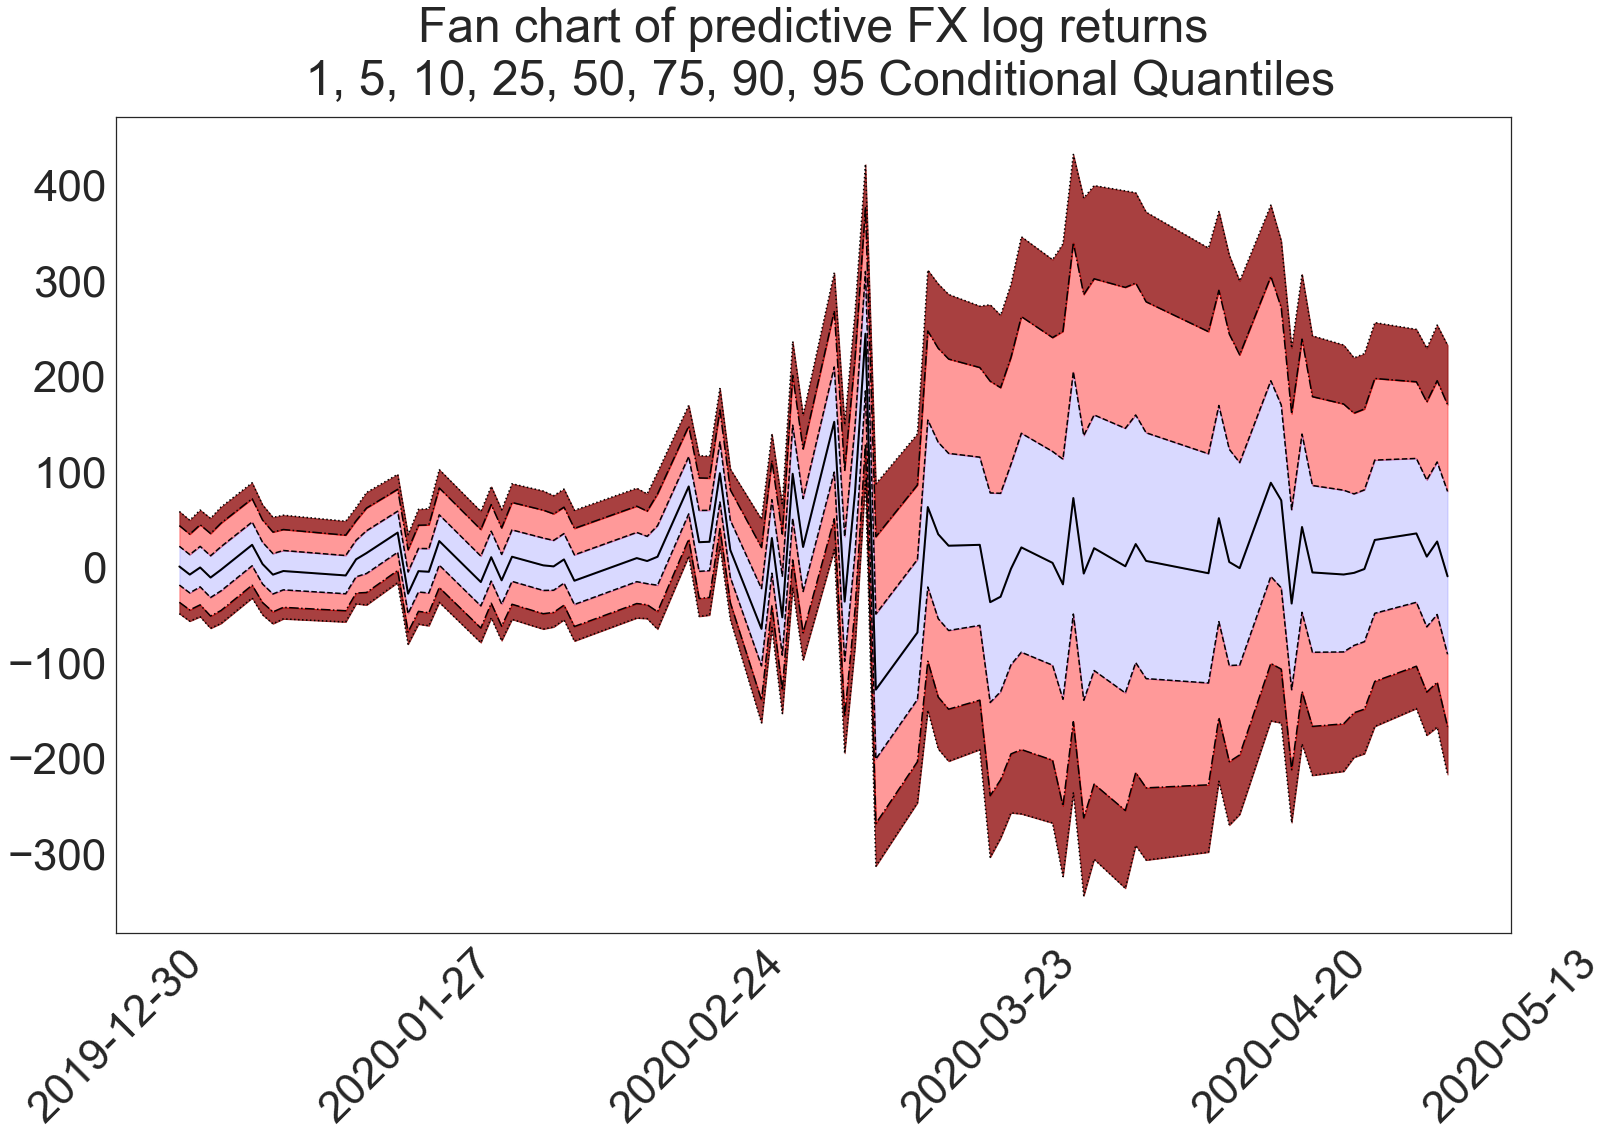

In [9]:
dgfor.plot_fan_chart(font_scale=4, xticks_freq=28)
plt.show()


### Figure 6. Probability Integral Transform Test

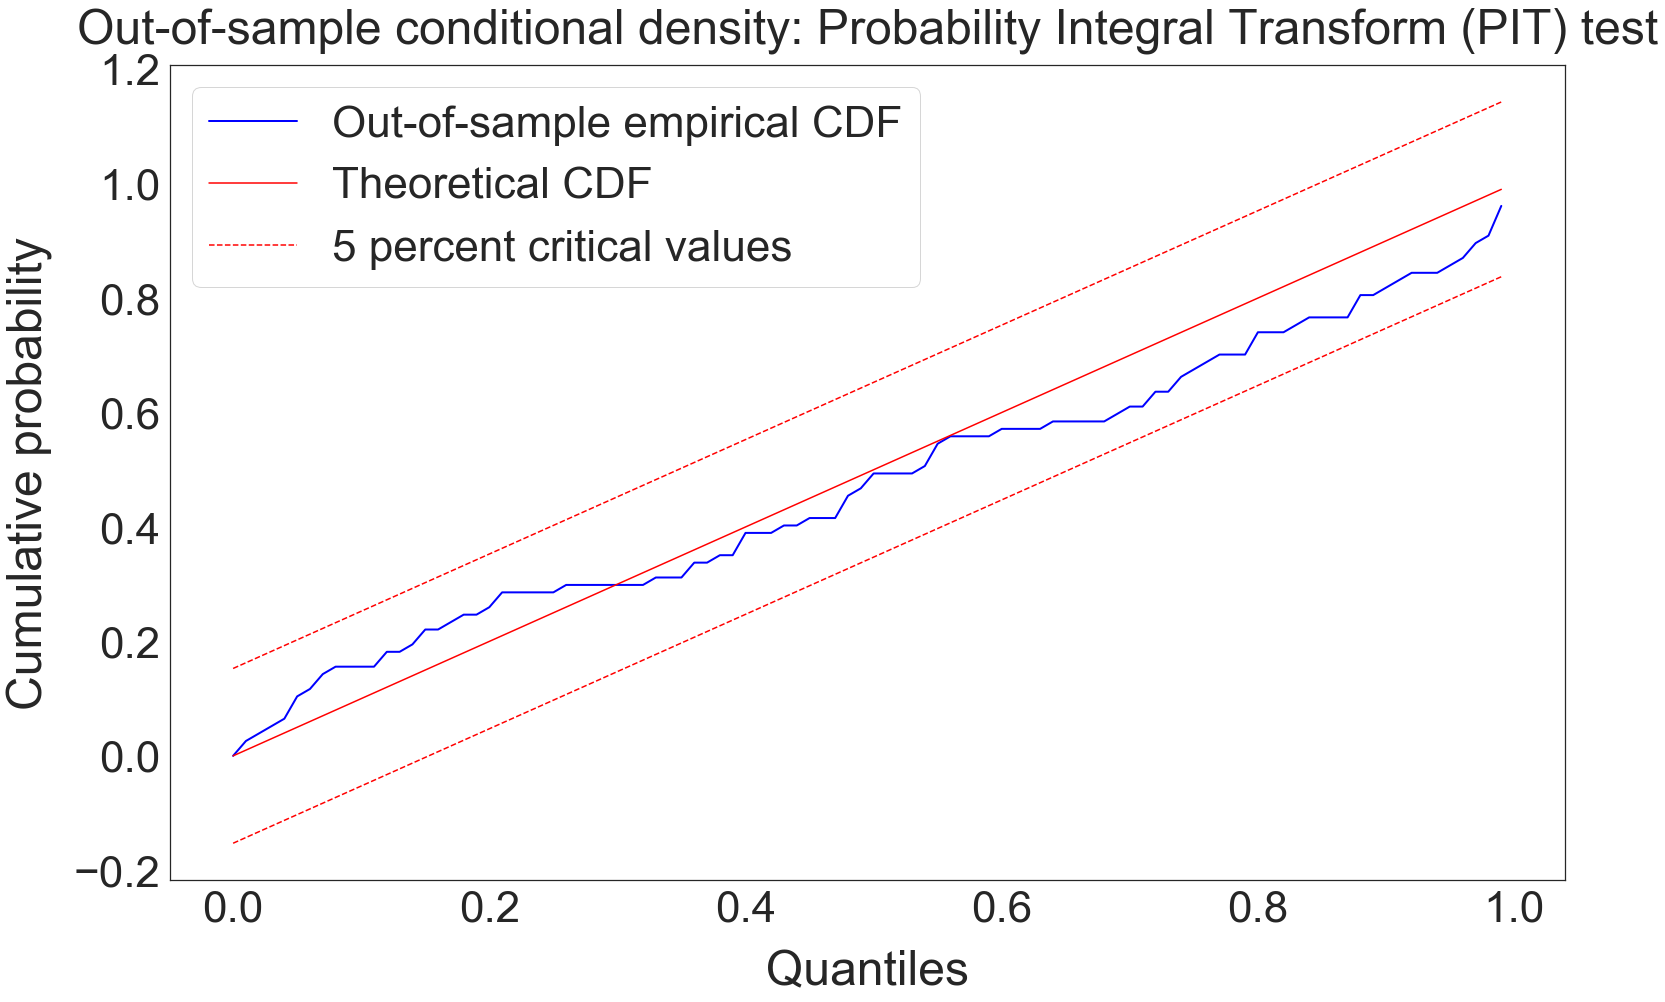

In [10]:
dgfor.pit_plot(font_scale=4)
plt.show()


### Figure 7. VaR FX Interventions Rule Based on a Given Information Set

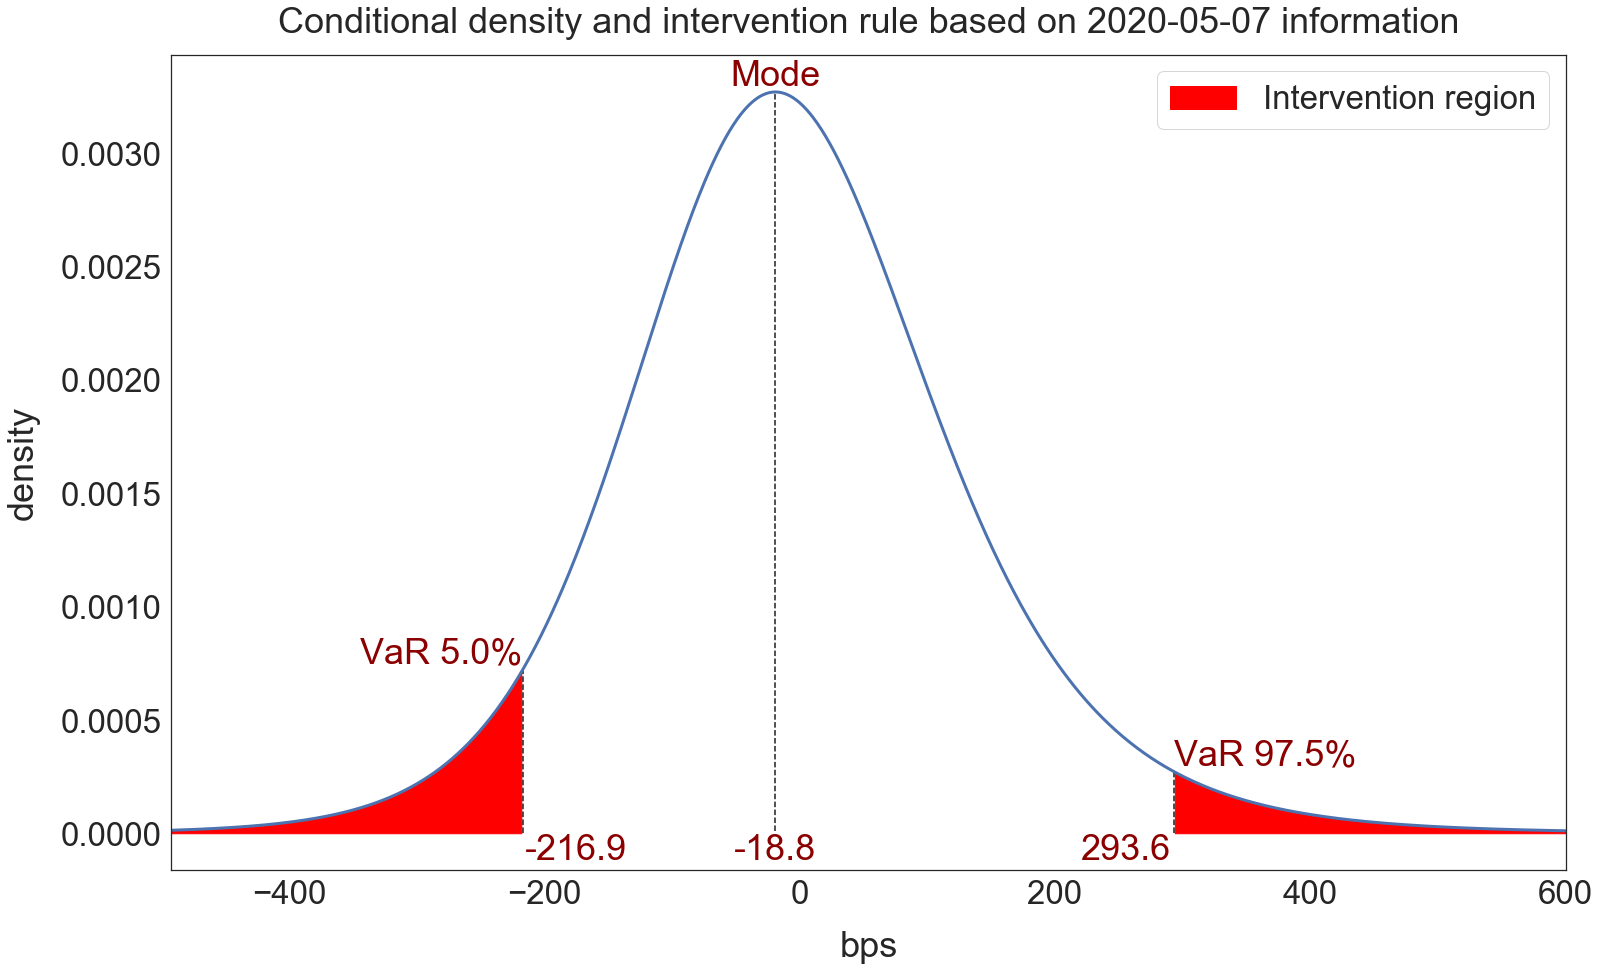

In [11]:
dgfor.plot_pdf_rule(q_low=0.05, q_high=0.975, font_scale=3)
plt.show()


### Figure 8. Conditional CDF, Out-of-sample

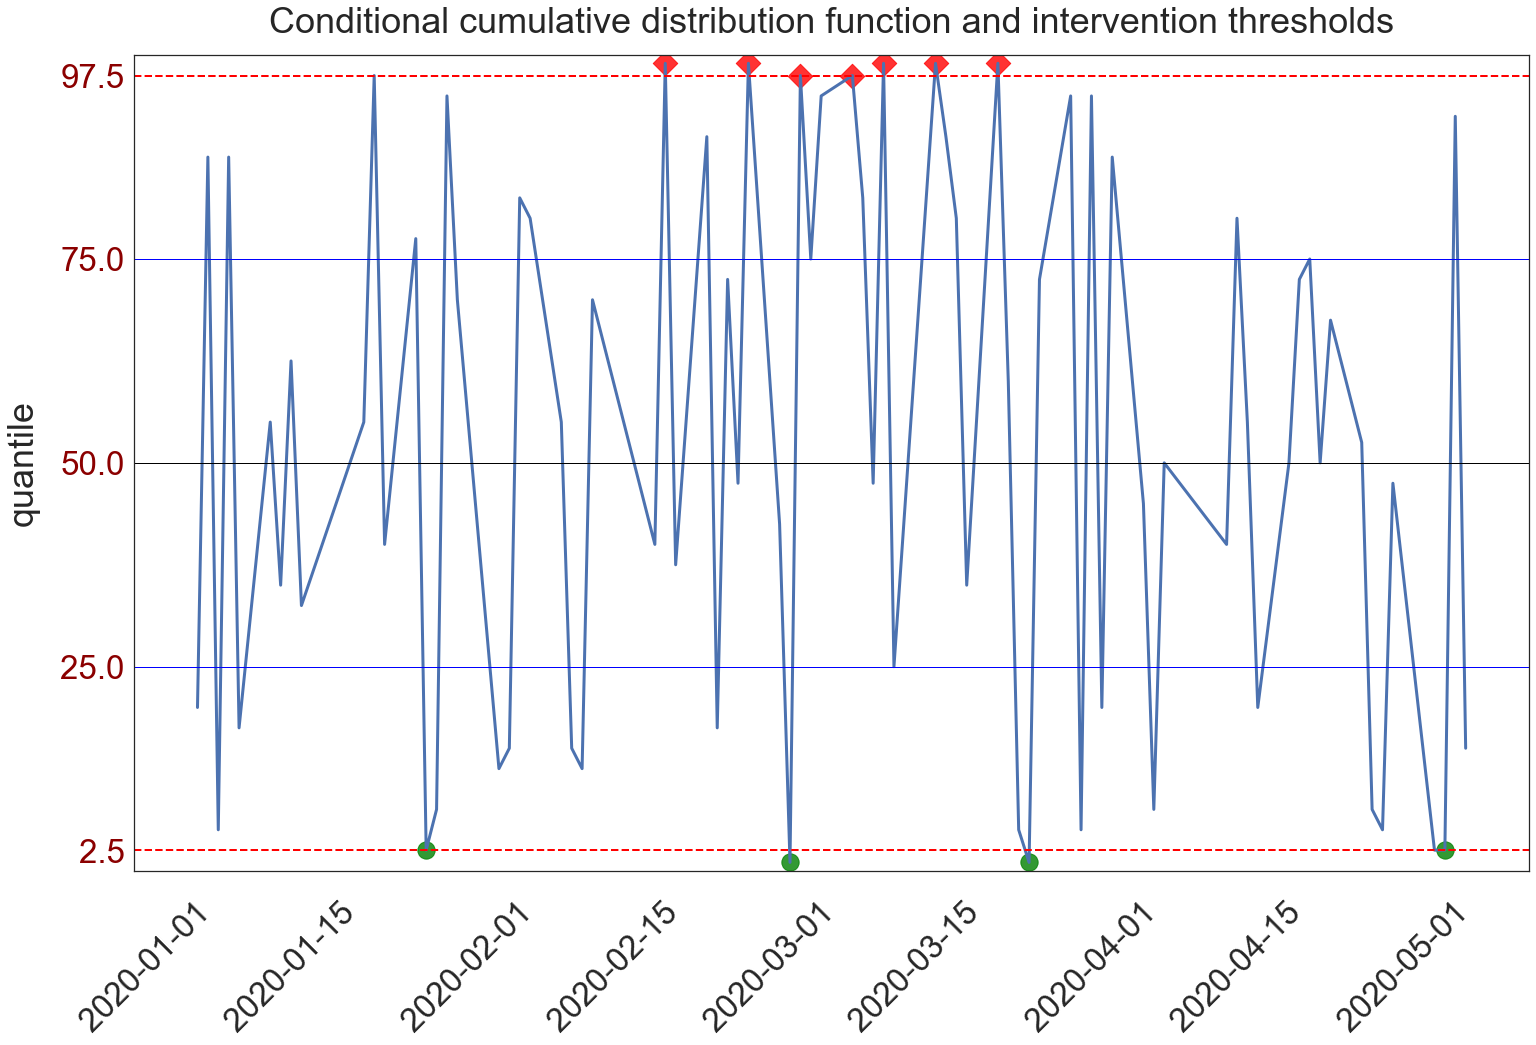

In [12]:
dgfor.plot_conditional_cdf(font_scale=3, q_low=0.025, q_high=0.975, size=300)
plt.show()


### Figure 9. Conditional VaR Exceedance, Out-of-Sample

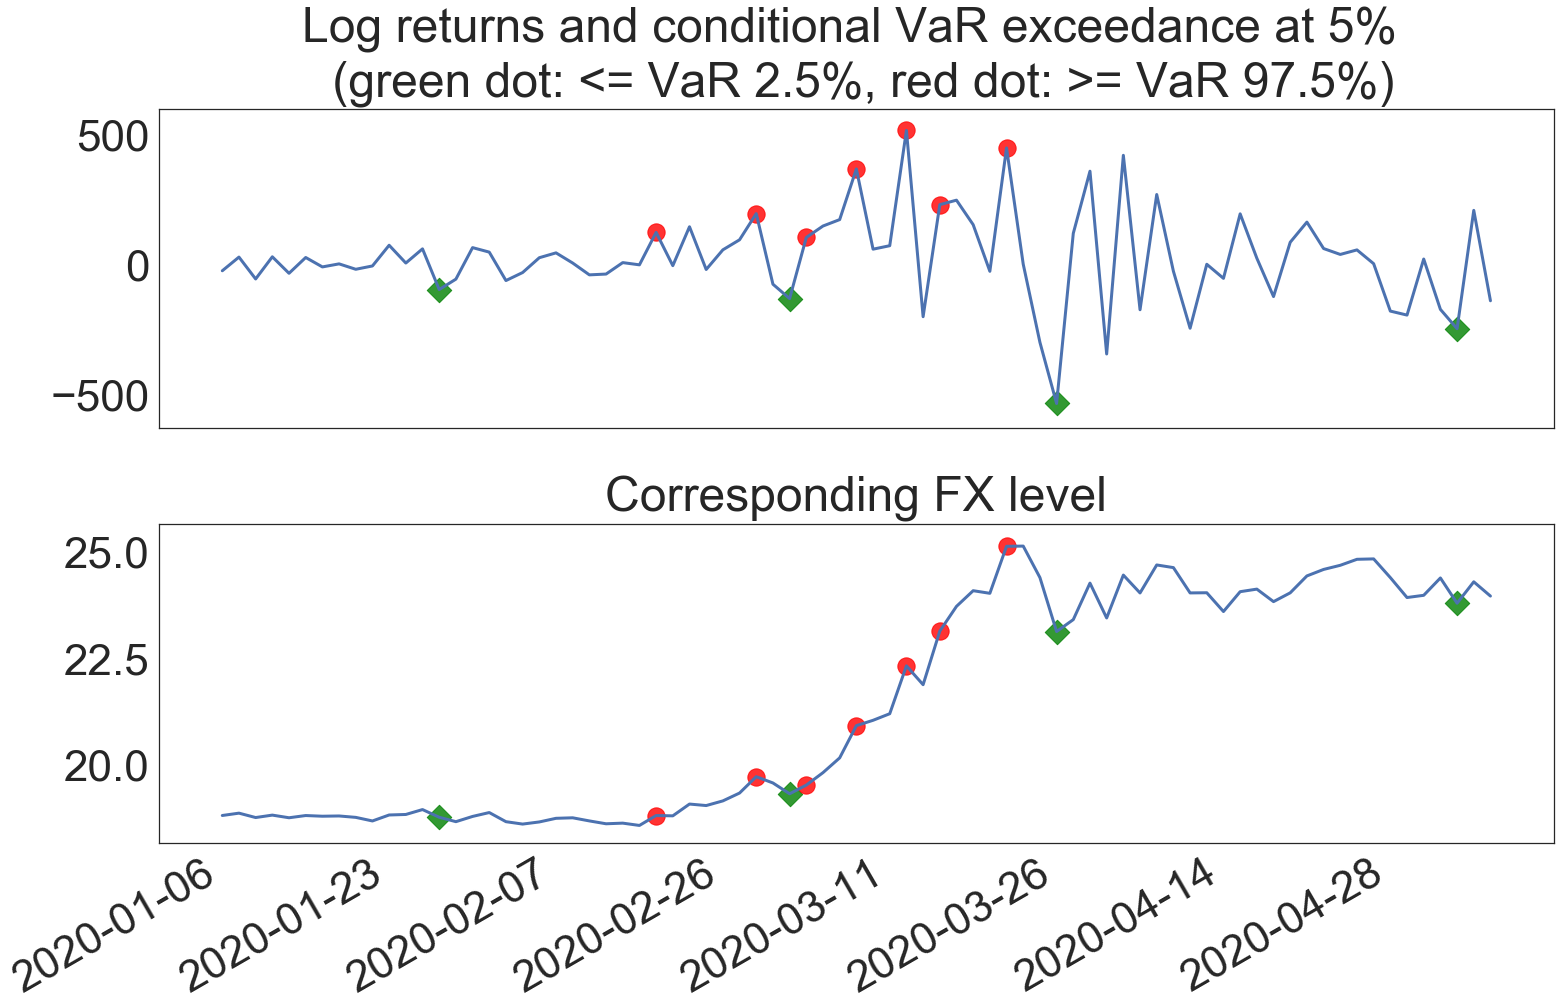

In [13]:
dgfor.plot_var_exceedance(qv_l=[0.025, 0.975], 
                          title_1= ('Log returns and conditional VaR exceedance at 5%'
                        ' \n (green dot: <= VaR 2.5%, red dot: >= VaR 97.5%)'),
                          title_2='Corresponding FX level',
                          swap_color=True, 
                          font_scale=4, size=300)
plt.show()



## Benchmarking exercise

In [14]:
# Read the interventions dataframe
dmx = pd.read_csv(os.path.join('data', 'intervention_data.csv'), parse_dates=['date'], index_col=0)

# Merge with the MXN peso database
dfxi = pd.merge(df, dmx[['Sell amount', 'type']],
                left_index=True, right_index=True, how='outer')

# Forecast over the Banco Mexico intervention period for benchmarking
dgmfor = dgf.forecast(dmx.index.min() - relativedelta(days=1), horizon=1)

# Include the forecasted results within the original dataframe
dfxi = dfxi.merge(dgmfor.dfor, left_index=True, right_index=True, how='outer')

# New variables
dfxi['FXI'] = (dfxi['Sell amount'] >0)
cond_fxi = (dfxi['FXI']==True)

dfxi['FXI current rate'] = np.nan
dfxi.loc[cond_fxi, 'FXI current rate'] = dfxi.loc[cond_fxi, 'FX level'].copy()

dfxi['FXI current logret'] = np.nan
dfxi.loc[cond_fxi,'FXI current logret'] = dfxi.loc[cond_fxi, 'FX log returns']

dfxi['FXI cdf'] = np.nan
dfxi.loc[cond_fxi, 'FXI cdf'] = dfxi.loc[cond_fxi, 'norm_true_val_cdf']

# Differentiate between intervention types
dmfxi = dfxi.loc[dmx.index.min():dmx.index.max(), :].copy()
dfr = dmfxi.loc[dmfxi["type"]=='min price', :].copy() # Rule
dfd = dmfxi.loc[dmfxi["type"]=='no min price', :].copy() # Discretion


### Figure 10. Rule-based FX Interventions on the Mexican Peso/USD

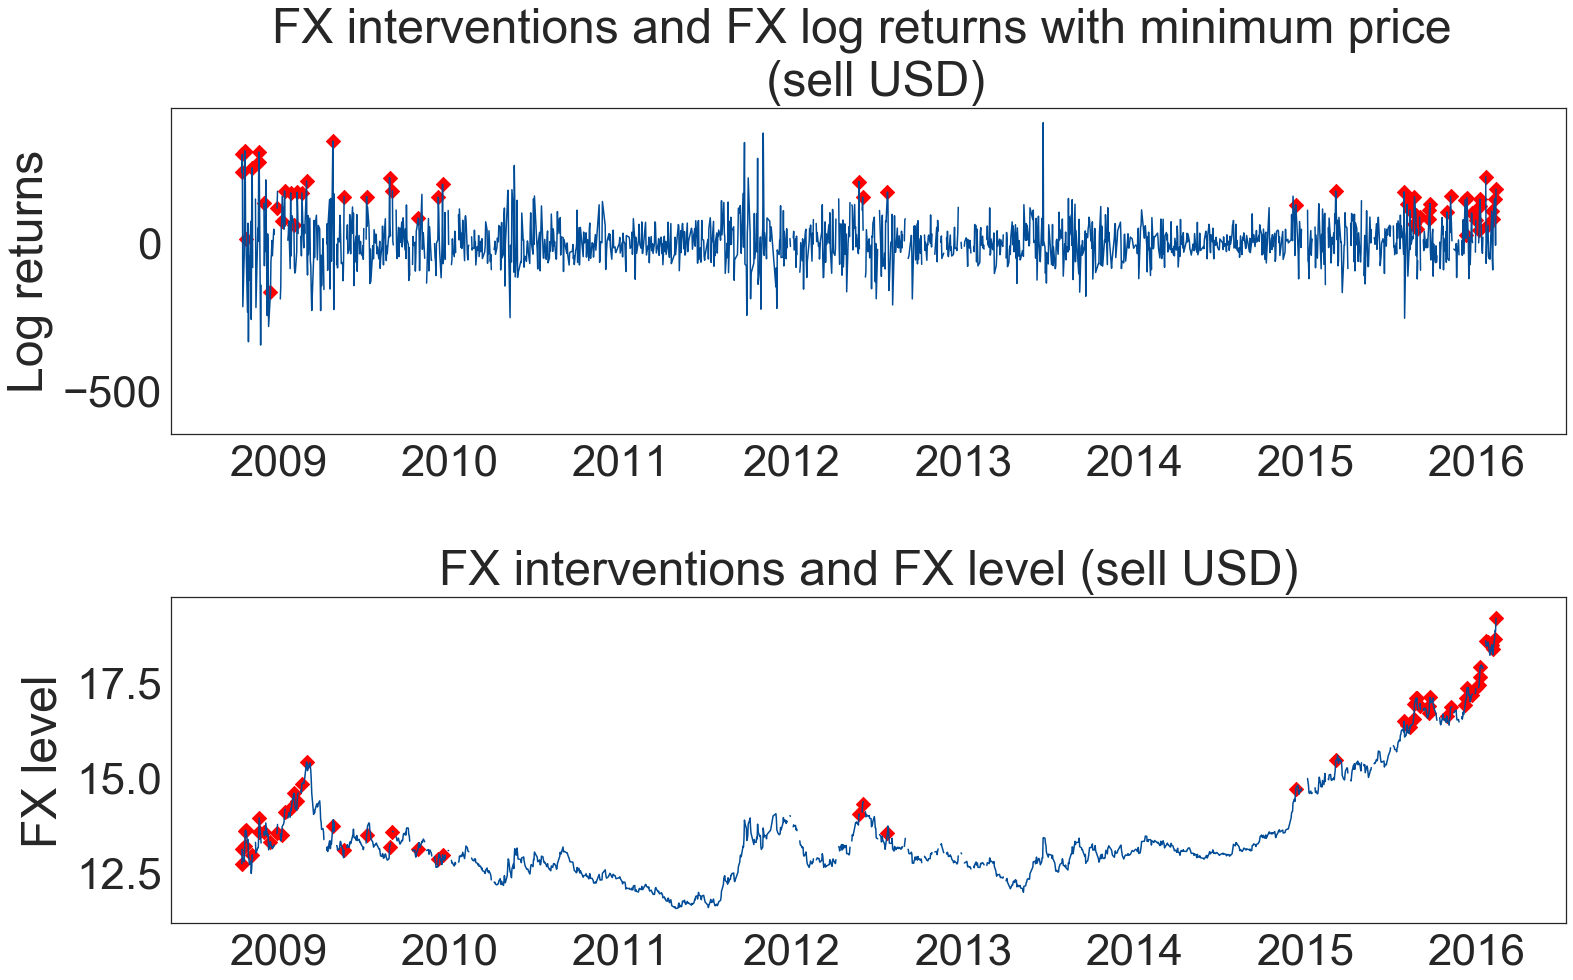

In [15]:
sns.set(style='white', font_scale=4, palette='deep', font='Arial')

# With minimum price (== rule based)
fig, (ax1, ax2) = plt.subplots(2,1)

# Log returns
ax1.plot(dmfxi.index, dmfxi['FX log returns'], color='#004C97')
ax1.scatter(dfr.index, dfr['FXI current logret'], s=100, color='red', marker='D')

ax1.set_title('FX interventions and FX log returns with minimum price '
              '\n (sell USD)',
              y=1.02)
ax1.set_xlabel('')
ax1.set_ylabel('Log returns', labelpad=10)

# Level
ax2.plot(dmfxi.index, dmfxi['FX level'], color='#004C97')
ax2.scatter(dfr.index, dfr['FXI current rate'], s=100, color='red', marker='D')

ax2.set_title('FX interventions and FX level (sell USD)',
              y=1.02)
ax2.set_xlabel('')
ax2.set_ylabel('FX level', labelpad=10)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
plt.show()


### Figure 11. Conditional CDF and Rule-based FX Interventions

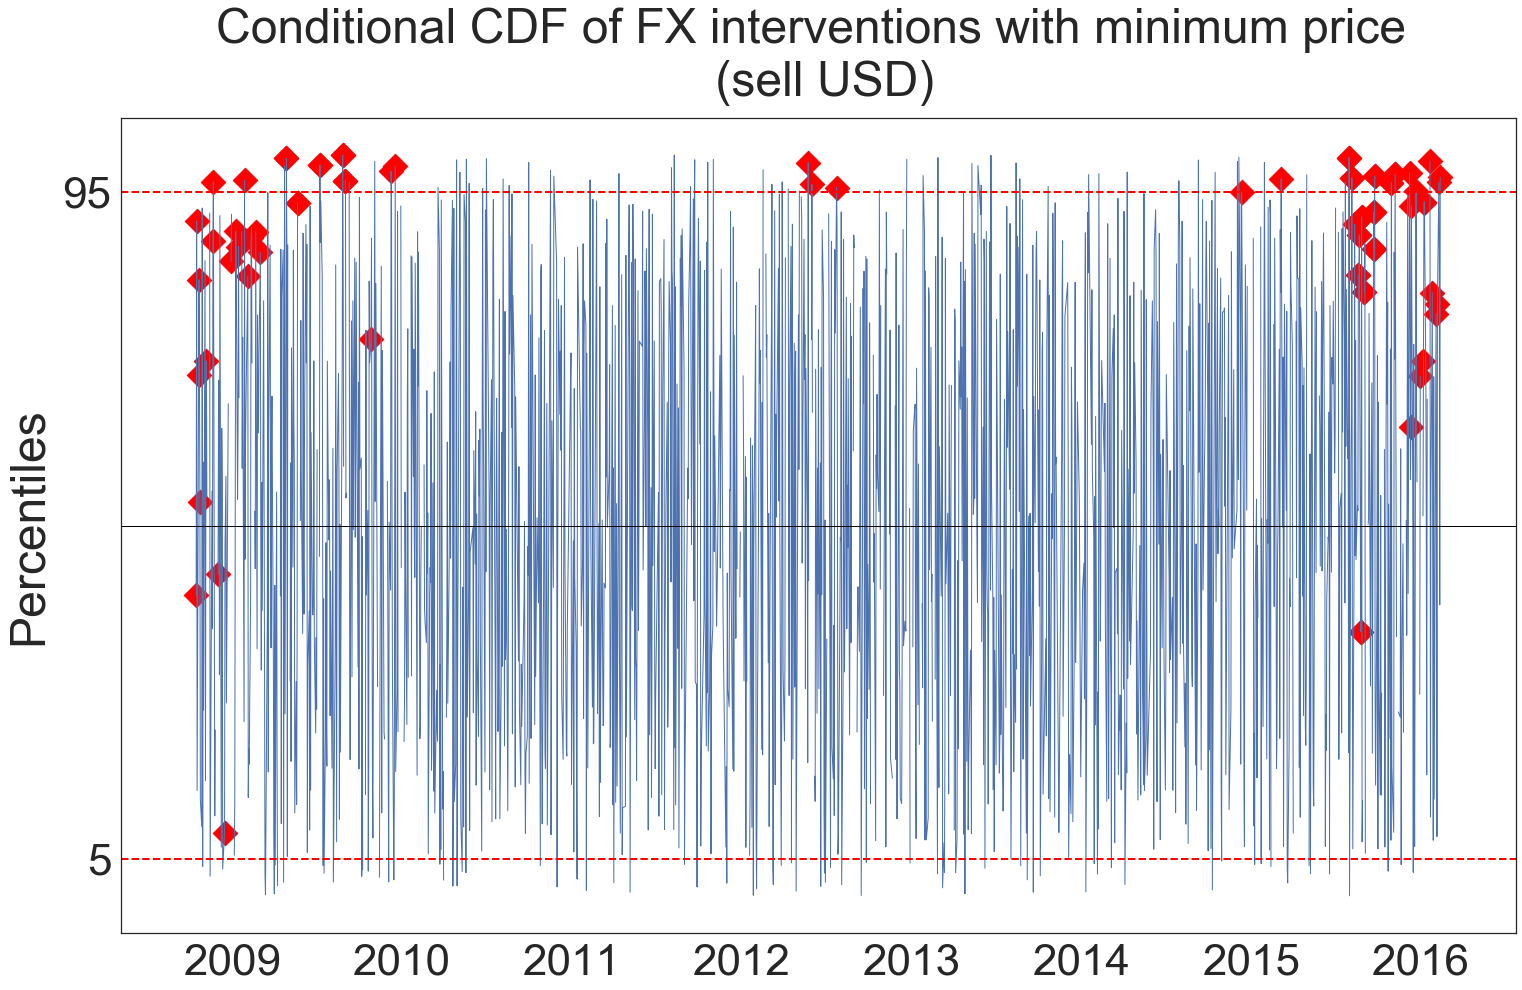

In [19]:
fig, ax1 = plt.subplots(1,1)

# Local merge to have the same axis
dr = pd.merge(dmfxi['norm_true_val_cdf'], dfr['FXI cdf'], left_index=True, right_index=True, how='left')

# Level plot
ax1.plot(dr.index, 100*dr['norm_true_val_cdf'], lw=1)
ax1.scatter(dr.index, 100*dr['FXI cdf'], alpha=1, c='red', marker='D', s=300)
ax1.set_title('Conditional CDF of FX interventions with minimum price \n (sell USD)',
              y=1.02)
ax1.set_xlabel('')
ax1.set_ylabel('Percentiles', labelpad=10)

ax1.axhline(y=5, color='red', linestyle='--', lw=2)
ax1.axhline(y=95, color='red', linestyle='--', lw=2)
ax1.axhline(y=50, color='black', linestyle='-', lw=1)

# Add the ticks, if needed
ax1.set_yticks([]) # Remove the standard y ticks
new_t_l = [5, 95]
new_ticks_l = sorted(list(ax1.get_yticks()) + new_t_l)
extra_idx_l = [new_ticks_l.index(x) for x in new_t_l]
ax1.set_yticks(new_ticks_l) # Add new ticks

ax1.set_ylim(-5, 105)
plt.show()




### Figure 12. Discretionary FX Interventions on the Mexican Peso/USD

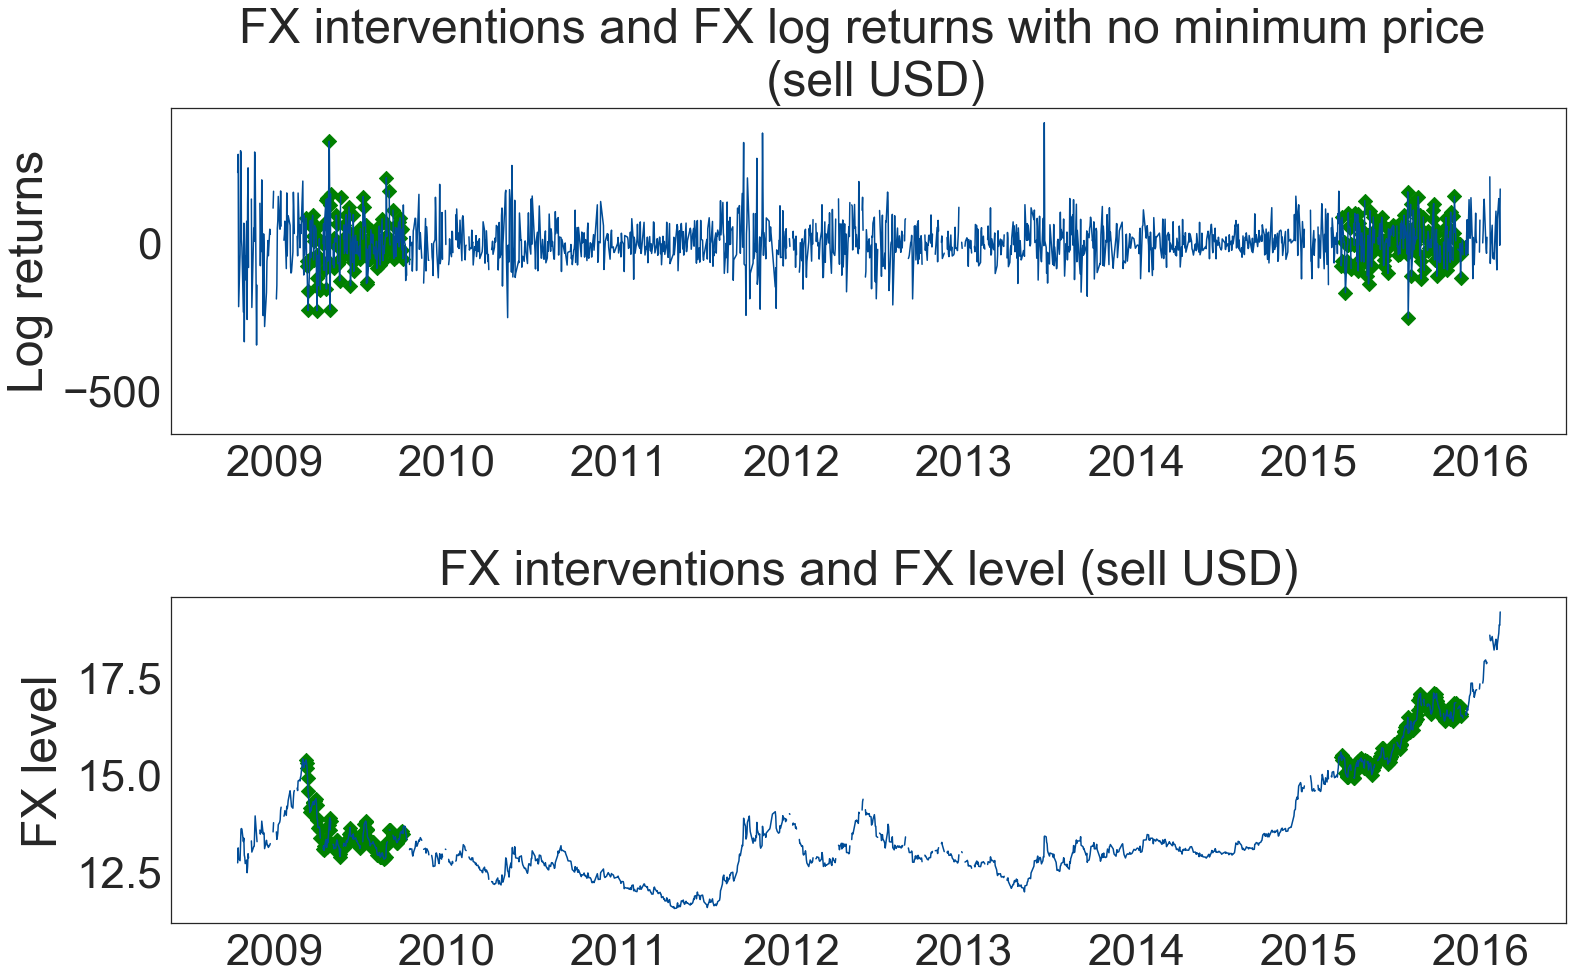

In [17]:
sns.set(style='white', font_scale=4, palette='deep', font='Arial')
fig, (ax1, ax2) = plt.subplots(2,1)

# Log returns
ax1.plot(dmfxi.index, dmfxi['FX log returns'], color='#004C97')
ax1.scatter(dfd.index, dfd['FXI current logret'],
            s=100, color='green',
            marker='D')

ax1.set_title('FX interventions and FX log returns with no minimum price '
              '\n (sell USD)',
              y=1.02)
ax1.set_xlabel('')
ax1.set_ylabel('Log returns', labelpad=10)

# Level
ax2.plot(dmfxi.index, dmfxi['FX level'], color='#004C97')
ax2.scatter(dfd.index, dfd['FXI current rate'], s=100, color='green',
            marker='D')

ax2.set_title('FX interventions and FX level (sell USD)',
              y=1.02)
ax2.set_xlabel('')
ax2.set_ylabel('FX level', labelpad=10)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
plt.show()


### Figure 13. Conditional CDF and Discretionary FX Interventions

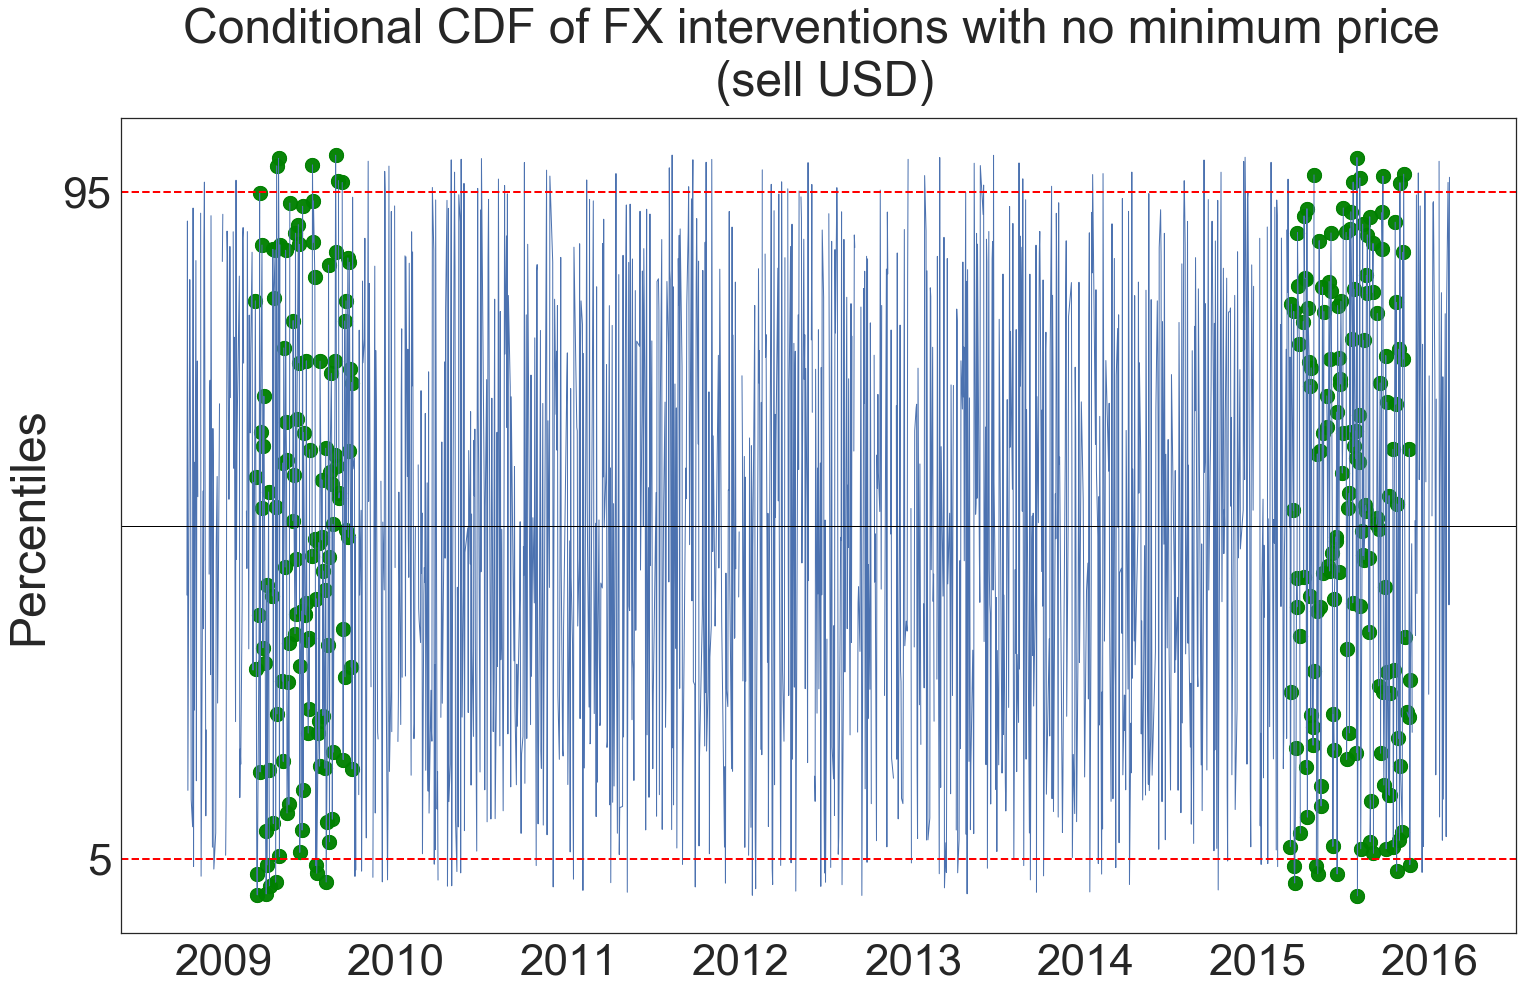

In [18]:
# Local merge to have the same axis
dd = pd.merge(dmfxi['norm_true_val_cdf'], dfd['FXI cdf'],
              left_index=True, right_index=True, how='left')

fig, ax1 = plt.subplots(1,1)
# Level plot
ax1.plot(dd.index, 100*dd['norm_true_val_cdf'], lw=1)
ax1.scatter(dd.index, 100*dd['FXI cdf'], alpha=0.8, c='green', marker='o', s=200)
ax1.set_title('Conditional CDF of FX interventions with no minimum price \n (sell USD)',
              y=1.02)
ax1.set_xlabel('')
ax1.set_ylabel('Percentiles', labelpad=10)

ax1.axhline(y=5, color='red', linestyle='--', lw=2)
ax1.axhline(y=95, color='red', linestyle='--', lw=2)
ax1.axhline(y=50, color='black', linestyle='-', lw=1)

# Add the ticks, if needed
ax1.set_yticks([]) # Remove the standard y ticks
new_t_l = [5, 95]
new_ticks_l = sorted(list(ax1.get_yticks()) + new_t_l)
extra_idx_l = [new_ticks_l.index(x) for x in new_t_l]
ax1.set_yticks(new_ticks_l) # Add new ticks

ax1.set_ylim(-5, 105)

plt.show()


#### The file ends here